In [1]:
import pbjam as pb
from pbjam.jar import session
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk 
import sys
import astropy.units as units
import pandas as pd
import lightkurve as lk
import importlib


In [2]:
kic = '4448777'
numax = [220.0, 3.0]
dnu = [16.97, 0.05]
teff = [4750, 100]
bp_rp = [1.34, 0.1]

In [3]:
lc = lk.search_lightcurvefile(kic, quarter=1).download().PDCSAP_FLUX.normalize().flatten(window_length=401)
for q in range(2,17):
    lc = lc.append(lk.search_lightcurvefile(kic, quarter=q).download().PDCSAP_FLUX.normalize().flatten(window_length=401))


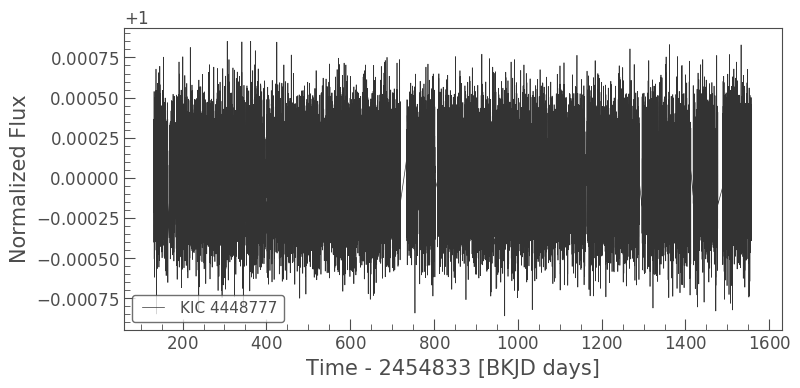

In [4]:
lc = lc.remove_outliers(4)
lc.plot()

In [5]:
pg = lc.to_periodogram(normalization='psd', minimum_frequency=150.0).flatten()

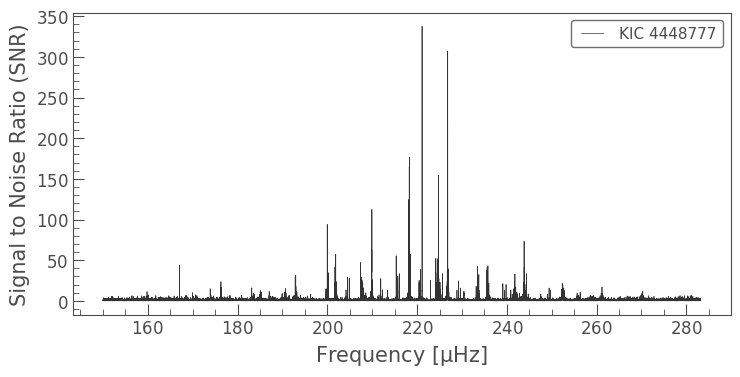

In [6]:
pg.plot()

In [7]:
ep = pb.epsilon()
result = ep(dnu=dnu, numax=numax, teff=teff, bp_rp=bp_rp, bw_fac=1.0)

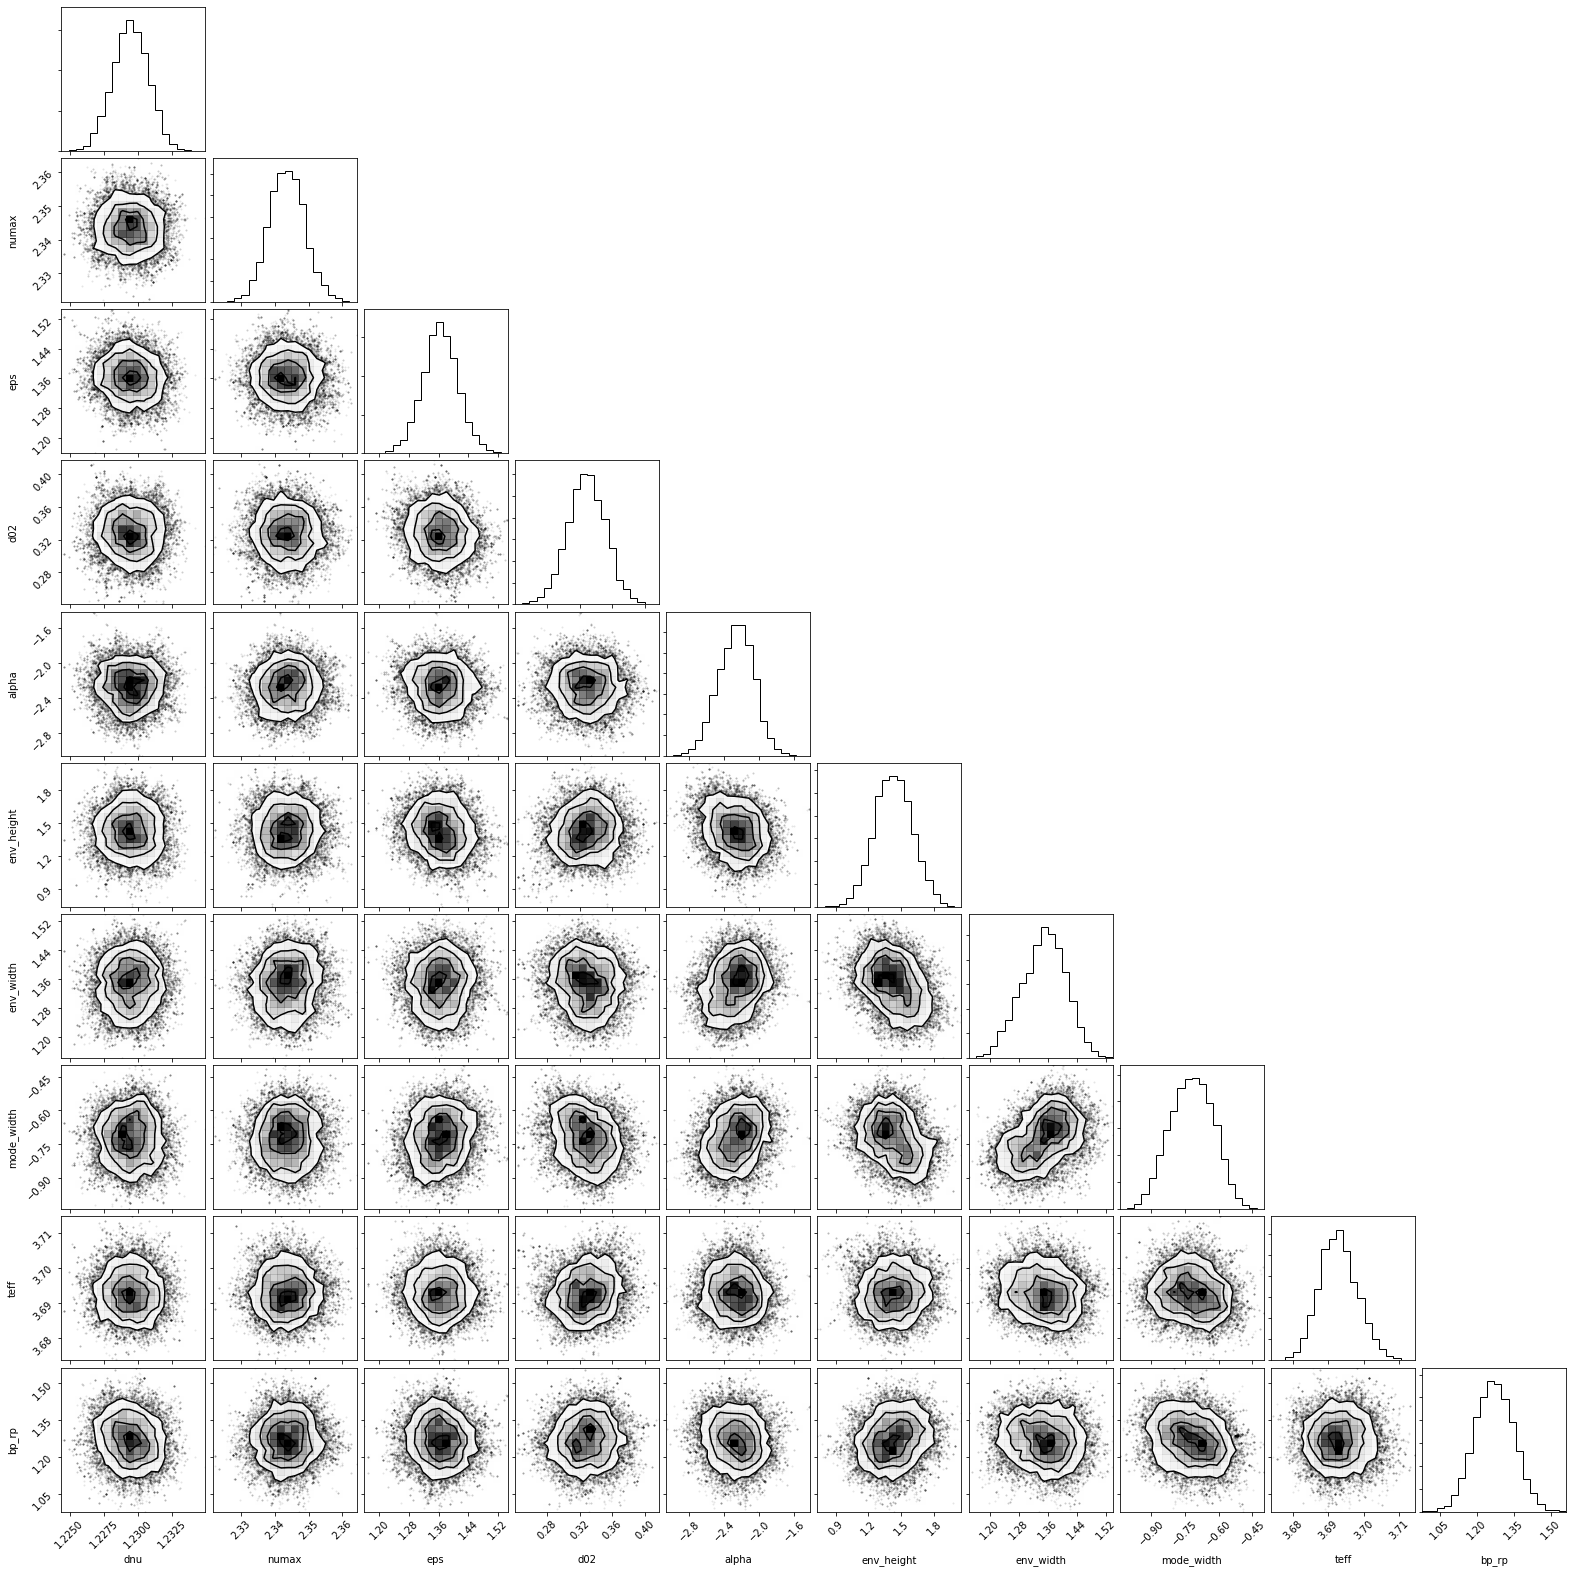

In [8]:
import corner
corner.corner(ep.samples, labels=ep.cols);

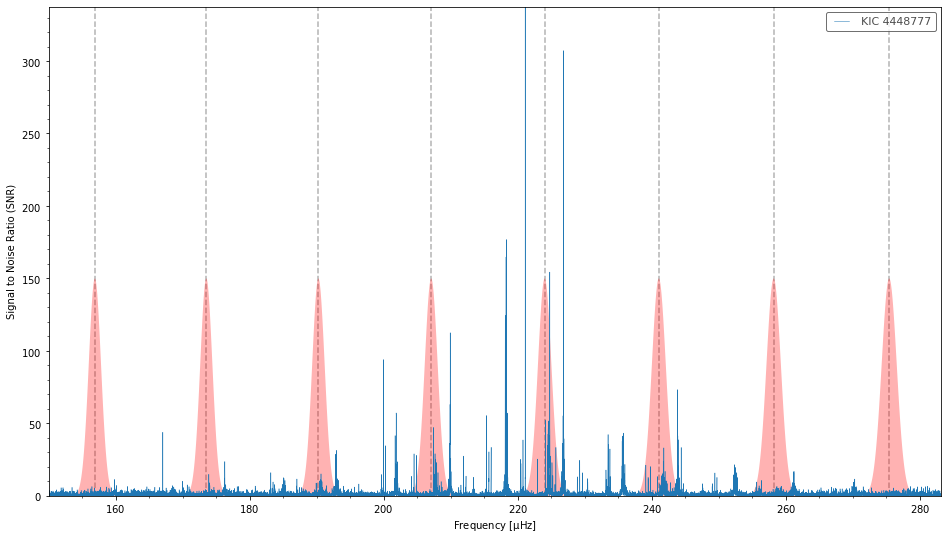

In [9]:
ep.plot(pg, h=150)

In [10]:
importlib.reload(pb.asy_peakbag)
asy = pb.asy_peakbag.asymptotic_fit(pg.frequency.value, pg.power.value, 
                                    ep.samples, 
                                    teff, bp_rp, 
                                    nthreads=4, norders=5,
                                    store_chains=True)

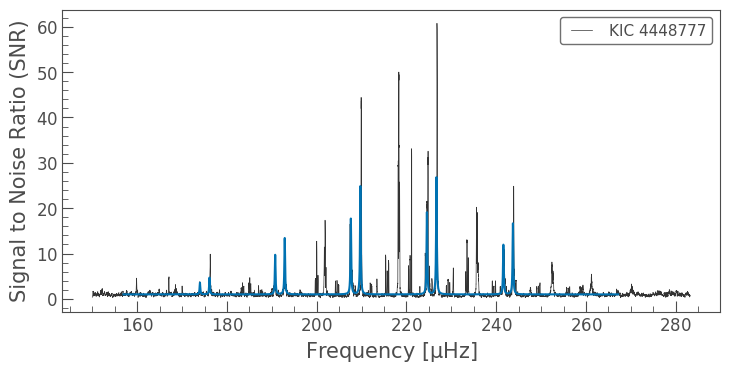

In [11]:
ax = pg.smooth().plot()
ax.plot(asy.model.f, asy.model(asy.start))

In [12]:
asy_result = asy.run(burnin=1000, niter=1000)

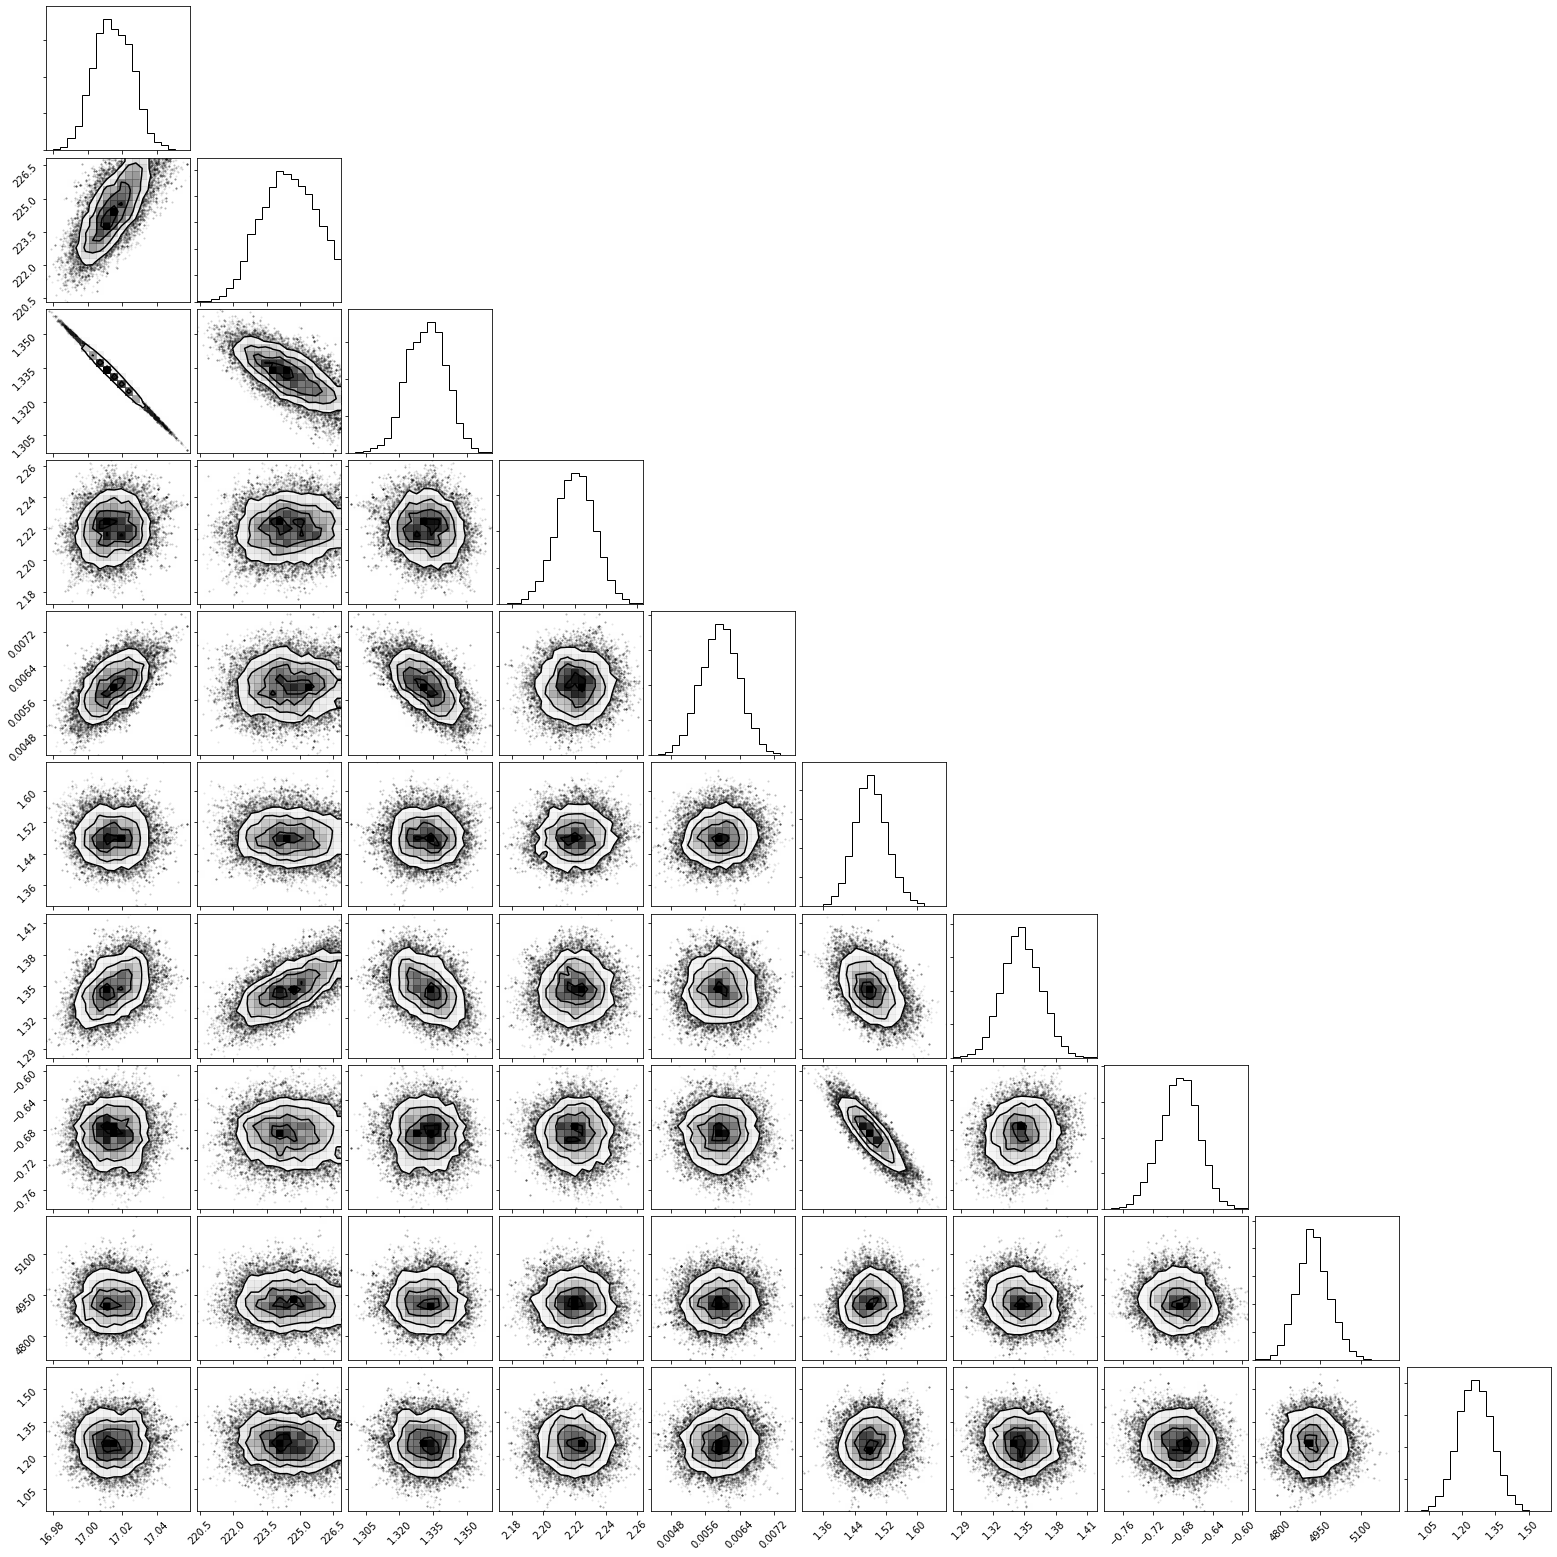

In [13]:
corner.corner(asy.flatchain);

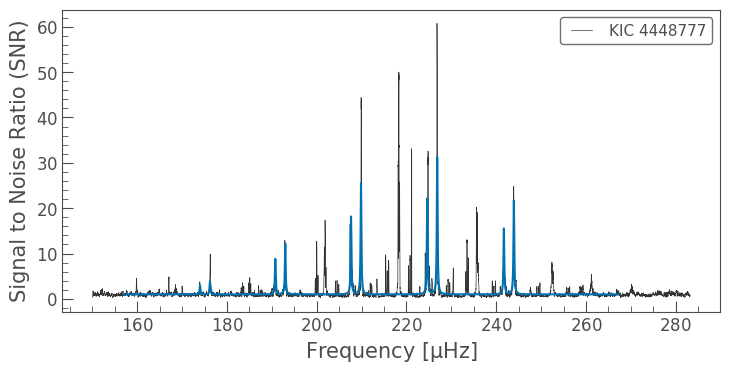

In [14]:
ax = pg.smooth().plot()
ax.plot(asy.model.f, asy.model(asy.flatchain.mean(axis=0)))

In [15]:
asy_result['summary']

,dnu,numax,eps,d02,alpha,env_height,env_width,mode_width,teff,bp_rp
mle,17.016177,224.879067,1.330887,2.215532,0.005854,1.475452,1.344625,-0.674309,4927.930975,1.243305
mean,17.014712,224.465972,1.332060,2.220435,0.005942,1.482123,1.347453,-0.684583,4925.209307,1.259301
std,0.011015,1.193038,0.008578,0.012261,0.000446,0.042032,0.018064,0.025570,60.329403,0.077577
skew,0.089340,-0.135873,-0.097184,-0.033434,-0.000990,0.155035,0.076282,-0.104294,0.217220,0.032486
2nd,16.993447,222.114104,1.314936,2.195407,0.005051,1.400406,1.312028,-0.737269,4809.746093,1.104110
16th,17.003613,223.178365,1.323226,2.208312,0.005481,1.440747,1.329492,-0.710394,4865.586751,1.182692
50th,17.014506,224.470463,1.332313,2.220429,0.005945,1.480678,1.346842,-0.683880,4922.487821,1.258455
84th,17.026063,225.770150,1.340757,2.232777,0.006384,1.523418,1.365840,-0.659140,4985.242977,1.337345
97th,17.036606,226.607698,1.348595,2.244697,0.006829,1.569984,1.384602,-0.635265,5053.110917,1.416382
MAD,0.011658,1.304004,0.009101,0.012172,0.000448,0.041126,0.017952,0.025449,57.915328,0.078961


In [16]:
from pbjam import peakbag 
import pymc3 as pm
import importlib

In [17]:
importlib.reload(peakbag)
pbag = peakbag.peakbag(pg.frequency.value, pg.power.value, asy_result)

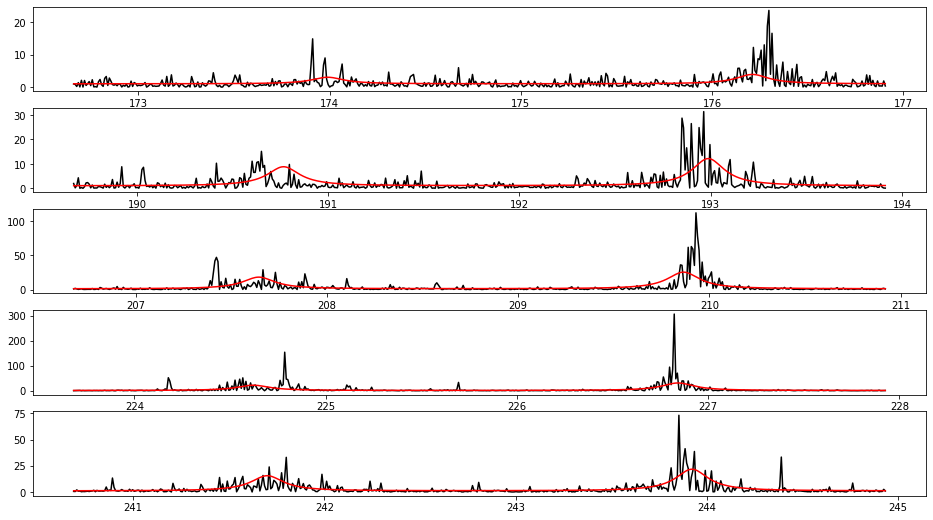

In [18]:
pbag.plot_start_model()

In [19]:
pbag.sample(model_type='simple', cores=4, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, width2, width0, l2, l0]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:23<00:00, 346.15draws/s]


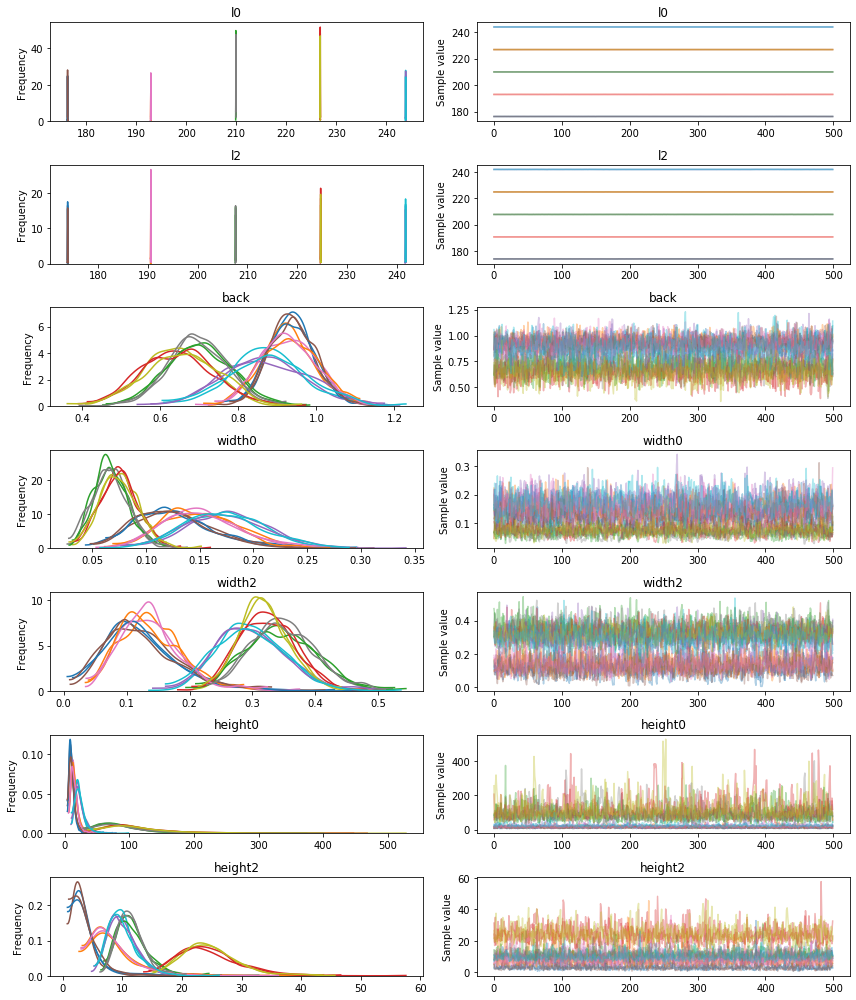

In [20]:
pbag.traceplot()

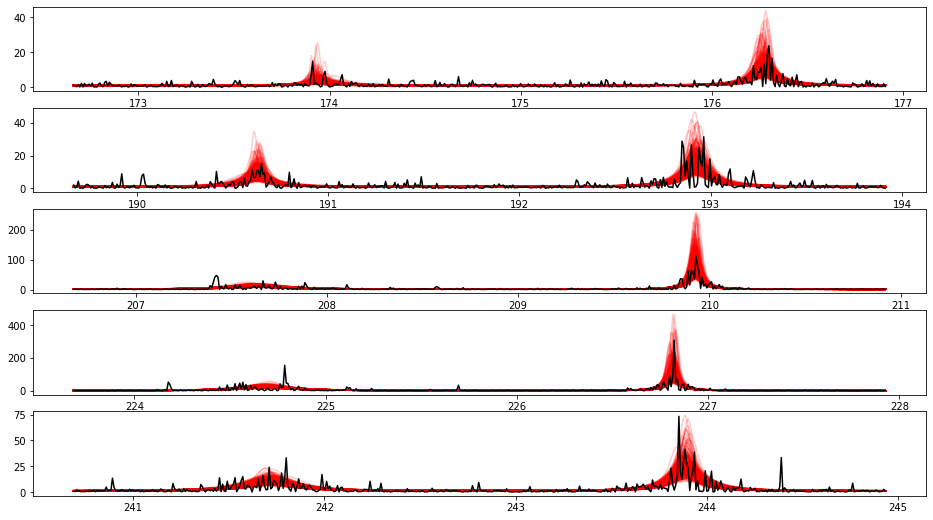

In [21]:
pbag.plot_fit(thin=1)